### 1 Loading Dataset

In [1]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import random
from torchvision import transforms

from models.my_datasets import MyDataset4
from models.my_models_alex2 import MyModel_CNN
#from models.my_models_alex import MyModel_CNN


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [4]:
'''
ROOT = './output/town04_image_data/images/'
OUT = './output/town04_image_data/smallimages/'
SIZE = (400,300)
image_paths = os.listdir(ROOT)
image_paths.sort()
for im in image_paths:
    #print(im)
    img = cv2.imread(ROOT+im)
    img = cv2.resize(img, SIZE,  interpolation = cv2.INTER_AREA)
    cv2.imwrite(OUT+im, img)
'''

"\nROOT = './output/town04_image_data/images/'\nOUT = './output/town04_image_data/smallimages/'\nSIZE = (400,300)\nimage_paths = os.listdir(ROOT)\nimage_paths.sort()\nfor im in image_paths:\n    #print(im)\n    img = cv2.imread(ROOT+im)\n    img = cv2.resize(img, SIZE,  interpolation = cv2.INTER_AREA)\n    cv2.imwrite(OUT+im, img)\n"

In [5]:
'''
#### delete the data for the unstored images
ROOT = './output/town04_image_data/'
out = open(ROOT+"alldata.txt",'w')
lines=[]
with open(ROOT+"offdata_image.txt", 'r') as infile:
    for line in infile:
        line = line.rstrip()
        words = line.split()
        img = cv2.imread(ROOT+words[0])
        if img is None:
            pass
        else:
            out.write(line)
            out.write('\r\n')
out.close()
'''

'\n#### delete the data for the unstored images\nROOT = \'./output/town04_image_data/\'\nout = open(ROOT+"alldata.txt",\'w\')\nlines=[]\nwith open(ROOT+"offdata_image.txt", \'r\') as infile:\n    for line in infile:\n        line = line.rstrip()\n        words = line.split()\n        img = cv2.imread(ROOT+words[0])\n        if img is None:\n            pass\n        else:\n            out.write(line)\n            out.write(\'\r\n\')\nout.close()\n'

In [6]:
'''
#### compute the delta imformation from the original information
ROOT = './output/town04_image_data/'
out = open(ROOT+"delta.txt",'w')
delta_data = np.empty((0,3))
with open(ROOT+"data_image_all.txt", 'r') as infile:
    for line in infile:
        line = line.rstrip()
        words = line.split()
        newline = np.array([[float(words[1])-float(words[2]), float(words[3]), float(words[4])]])
        delta_data = np.append(delta_data, newline, axis=0)
        
np.set_printoptions(threshold = np.inf)
out.write(str(repr(np.array(delta_data))))
out.close()
'''

'\n#### compute the delta imformation from the original information\nROOT = \'./output/town04_image_data/\'\nout = open(ROOT+"delta.txt",\'w\')\ndelta_data = np.empty((0,3))\nwith open(ROOT+"data_image_all.txt", \'r\') as infile:\n    for line in infile:\n        line = line.rstrip()\n        words = line.split()\n        newline = np.array([[float(words[1])-float(words[2]), float(words[3]), float(words[4])]])\n        delta_data = np.append(delta_data, newline, axis=0)\n        \nnp.set_printoptions(threshold = np.inf)\nout.write(str(repr(np.array(delta_data))))\nout.close()\n'

In [7]:
#preprocess the txt file
ROOT = './output/stereo/'
train_out = open(ROOT+"traindata_shuffle.txt",'w')
val_out = open(ROOT+"valdata_shuffle.txt",'w')
over_out = open(ROOT+"overdata_shuffle.txt",'w')
lines=[]
with open(ROOT+"delta_data.txt", 'r') as infile:
    for line in infile:
        lines.append(line)
    random.shuffle(lines)
    num_train = np.ceil(0.85*len(lines))
    for count, line in enumerate(lines):
        if count <=num_train:
            if count>=25 and count<=35:
                print(line)
                over_out.write(line)
            train_out.write(line)
        else:
            val_out.write(line) 
train_out.close()            
val_out.close()
over_out.close()        

images/04_0677_03.png 5.177994737786017 5.244937291026927 7.4184151467521815 -0.9081877793757497 -0.19768555007230368

images/07_0475_01.png 4.939601889216198 4.9358824127026795 6.696334783563353 1.503929031388164 0.14290758237562204

images/01_0800_04.png 13.67246923526685 13.694621386992829 12.550240206771377 -0.10333509704485344 -0.015234346699688931

images/06_0603_02.png 4.939506658524031 4.953176854162561 6.971258654552807 0.6692163425158713 -0.16309598194222988

images/00_0581_04.png 13.351369903172364 12.0786515429085 12.24244815175183 -0.6311132221606499 -0.07637639742821944

images/06_0374_03.png 0.00015949195833109254 0.0004754683164527831 3.6742240803014035 -0.090822019697196 0.04149496555209116

images/06_0946_01.png 5.140223343240088 5.093347672644068 6.848621398413161 -0.8902415893012292 -0.02675903313635385

images/06_0869_00.png 5.140121894045212 5.0907246638203425 6.914950483099203 0.3066388222771309 0.02673132621723275

images/00_0911_01.png 15.983360174848347 15.984

In [8]:
TRANSFORM = transforms.Compose([#transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.5,), (0.5, ))])
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
SIZE = (128,128)
over_data = MyDataset4(root = ROOT, txtname = 'overdata_shuffle.txt', transform=TRANSFORM, size=SIZE)
train_data = MyDataset4(root = ROOT, txtname = 'traindata_shuffle.txt' , transform = TRANSFORM, size= SIZE)
val_data = MyDataset4(root = ROOT, txtname = 'valdata_shuffle.txt', transform = TRANSFORM, size= SIZE)
over_loader = DataLoader(dataset=over_data, batch_size=64, shuffle=True)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=64, shuffle=True)
print("Overfit size: %i" % len(over_data))
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))

Overfit size: 11
Train size: 40801
Validation size: 7199


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 128, 128])


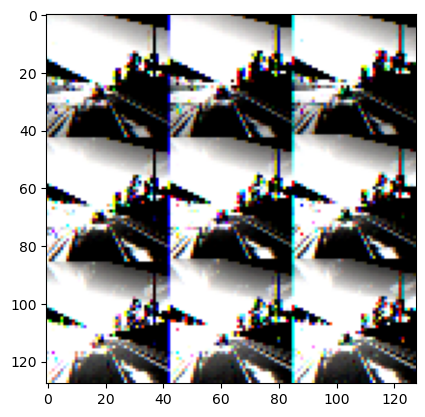

In [9]:
print(over_data[0][0][0].shape)
plt.imshow(over_data[0][0][0].view(128,128,3))
plt.show()
#cv2.imshow('Window',over_data[0][0][0])
#cv2.waitKey(0)
#cv2.destroyAllWindows()

### 2 Defining Neural Network

In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [11]:
mynet= MyModel_CNN().to(device)
print(mynet)

MyModel_CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (extra): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (predict): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(

In [12]:
#mynet.apply(init_weights)

In [13]:
total_params = sum(p.numel() for p in mynet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in mynet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

2,486,467 total parameters.
2,486,467 trainable parameters.


### 3 Training Neural network

In [14]:
mycriterion = nn.MSELoss(reduction='mean') 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-6, eps = 1e-08) 

In [15]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss1 = 0.0  
    running_loss2 = 0.0
    running_loss3 = 0.0  
    #running_loss4 = 0.0
    #running_loss5 = 0.0
    #Iterating through the minibatches of the data
    for i, data in enumerate(dataloader, 0):
        X, y1, y2, y3 = data
        X = [x.cuda() for x in X]
        y1 = y1.to(device).float()
        y2 = y2.to(device).float()
        y3 = y3.to(device).float()
        #y4 = y4.to(device).float()
        #y5 = y5.to(device).float()
        #Y = [y.cuda() for y in Y]
        #X = torch.tensor(X)
        #Y = torch.as_tensor(np.array(Y))
        #print(X.shape)
        if iftrain:  
            optimizer.zero_grad()
            y_pred = model(X)
            y_pred1 = y_pred[:,0].float()
            y_pred2 = y_pred[:,1].float()
            y_pred3 = y_pred[:,2].float()
            #y_pred4 = y_pred[:,3].float()
            #y_pred5 = y_pred[:,4].float()
            loss1 = criterion(y_pred1, y1)
            loss2 = criterion(y_pred2, y2) 
            loss3 = criterion(y_pred3, y3)
            #loss4 = criterion(y_pred4, y4) 
            #loss5 = criterion(y_pred5, y5) 
            loss = loss1 + loss2 + loss3 #+ (loss4 + loss5)
            #print(y)
            #print(y_pred)
            loss.backward()             
            optimizer.step()            
            running_loss1 += loss1.item() 
            running_loss2 += loss2.item() 
            running_loss3 += loss3.item() 
            #running_loss4 += loss4.item() 
            #running_loss5 += loss5.item()
            #print('x', X[1])
            #print('prediction', y_pred1)
            #print('gt', y1)
        else:
            y_pred = y_pred = model(X)
            y_pred1 = y_pred[:,0].float()
            y_pred2 = y_pred[:,1].float()
            y_pred3 = y_pred[:,2].float()
            #y_pred4 = y_pred[:,3].float()
            #y_pred5 = y_pred[:,4].float()
            loss1 = criterion(y_pred1, y1)
            loss2 = criterion(y_pred2, y2)
            loss3 = criterion(y_pred3, y3)
            #loss4 = criterion(y_pred4, y4) 
            #loss5 = criterion(y_pred5, y5)
            loss = loss1 + loss2 + loss3 #+ (loss4 + loss5)
            running_loss1 += loss1.item() 
            running_loss2 += loss2.item() 
            running_loss3 += loss3.item() 
            #running_loss4 += loss4.item() 
            #running_loss5 += loss5.item()
    return running_loss1, running_loss2, running_loss3 #, running_loss4, running_loss5

In [16]:
# test if the model will overfit with only one sample
max_epochs = 300
train_history = np.empty([0, 3], dtype=float) 
val_history = np.empty([0, 3], dtype=float) 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-4, eps = 1e-08) 
#scheduler = optim.lr_scheduler.CosineAnnealingLR(myoptimizer, max_epochs)
for epoch in range(max_epochs): 
    '''
    if epoch >= 1999 and epoch <= 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-5
    elif epoch > 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-6
    scheduler.step()
    '''
    train_loss1, train_loss2, train_loss3 = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=True)
    train_history = np.append(train_history, np.array([[train_loss1, train_loss2, train_loss3]]), axis=0)
    val_loss1, val_loss2, val_loss3 =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=False)
    val_history = np.append(val_history, np.array([[val_loss1, val_loss2, val_loss3]]), axis=0)
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1}/{max_epochs}")
        print('Delta X: train_loss: %2e, val_loss: %2e'%(train_loss1, val_loss1))
        print('Delta Y: train_loss: %2e, val_loss: %2e'%(train_loss2, val_loss2))
        print('Delta yaw: train_loss: %2e, val_loss: %2e'%(train_loss3, val_loss3))
        #print('Throttle: train_loss: %2e, val_loss: %2e'%(train_loss4, val_loss4))
        #print('Steering Angle: train_loss: %2e, val_loss: %2e'%(train_loss5, val_loss5))
        #print(scheduler.get_last_lr())

Epoch 10/300
Delta X: train_loss: 1.093194e+01, val_loss: 8.403063e+00
Delta Y: train_loss: 2.595179e-01, val_loss: 3.549684e-01
Delta yaw: train_loss: 1.531648e-01, val_loss: 1.415533e-01
Epoch 20/300
Delta X: train_loss: 5.798299e-01, val_loss: 5.649943e-01
Delta Y: train_loss: 1.876100e-01, val_loss: 1.944055e-01
Delta yaw: train_loss: 1.603008e-02, val_loss: 1.793297e-02
Epoch 30/300
Delta X: train_loss: 9.704798e-02, val_loss: 1.098832e-01
Delta Y: train_loss: 8.031233e-02, val_loss: 6.866683e-02
Delta yaw: train_loss: 7.024089e-03, val_loss: 5.710218e-03
Epoch 40/300
Delta X: train_loss: 4.516954e-02, val_loss: 2.447319e-02
Delta Y: train_loss: 1.052948e-02, val_loss: 7.293872e-03
Delta yaw: train_loss: 2.996831e-03, val_loss: 3.292222e-03
Epoch 50/300
Delta X: train_loss: 3.248415e-02, val_loss: 2.633396e-02
Delta Y: train_loss: 4.252010e-03, val_loss: 3.730611e-03
Delta yaw: train_loss: 9.161619e-04, val_loss: 7.310685e-04
Epoch 60/300
Delta X: train_loss: 7.706764e-03, val_los

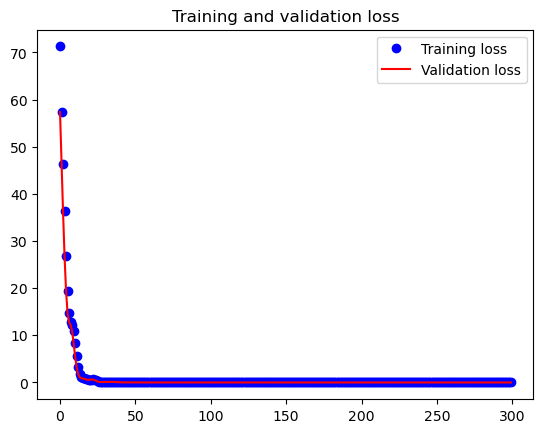

In [17]:
# plot the train&validation loss curve with only one sample
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history[:,0], 'bo', label='Training loss')
plt.plot(epochs, val_history[:,0], 'r', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [18]:
mynet.eval()
TEST = random.randint (0, 11)
test_in, gt_X, gt_Y, gt_yaw = over_data[TEST]
test_in = [torch.tensor(x).to(device) for x in test_in]
gt_output = [gt_X, gt_Y, gt_yaw]
gt_output = torch.tensor(gt_output)
output_pred = mynet(test_in) 
#print('TEST', TEST)
#print('test_in',test_in[1])
print('prediction:{},\nground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output))

prediction:[[ 6.848621   -0.89024174 -0.02675917]],
ground truth:tensor([ 6.8486, -0.8902, -0.0268], dtype=torch.float64)


/home/melina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [19]:
# start the main training process

num_trainbatch = np.ceil(len(train_data)/64) 
num_valbatch = np.ceil(len(val_data)/64) 
train_history = np.empty([0, 3], dtype=float) 
val_history = np.empty([0, 3], dtype=float) 

min_loss = 100000
current_patience = 0
patience = 5



In [22]:
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-7, eps = 1e-08) 
max_epochs = 50
print('Start training!')
for epoch in range(max_epochs): 
    
    if epoch >= 50:
        myoptimizer.param_groups[0]['lr'] = 1e-6
    
    
    train_loss1, train_loss2, train_loss3 = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader,
                           iftrain=True)
    train_history = np.append(train_history, np.array([[train_loss1, train_loss2, train_loss3]])/num_trainbatch, axis=0)
    val_loss1, val_loss2, val_loss3 =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader,
                           iftrain=False)
    val_history = np.append(val_history, np.array([[val_loss1, val_loss2, val_loss3]])/num_valbatch, axis=0)
    #if epoch % 10 == 9:
    print(f"Epoch {epoch + 1: >3}/{max_epochs}")
    print('Delta X: train_loss: %2e, val_loss: %2e'%(train_history[-1][0], val_history[-1][0]))
    print('Delta Y: train_loss: %2e, val_loss: %2e'%(train_history[-1][1], val_history[-1][1]))
    print('Delta yaw: train_loss: %2e, val_loss: %2e'%(train_history[-1][2], val_history[-1][2]))
    #print('Throttle: train_loss: %2e, val_loss: %2e'%(train_history[-1][3], val_history[-1][3]))
    #print('Steering Angle: train_loss: %2e, val_loss: %2e'%(train_history[-1][4], val_history[-1][4]))
'''
    # early stopping
    if min_loss == 100000 or val_loss < min_loss :
        min_loss = val_loss
        current_patience = 0
        torch.save(mynet.state_dict(),'mynet.pth')
      
    else :
        current_patience += 1 
        if current_patience >= patience :
            print("Stopping early at epoch {}!".format(epoch+1)) 
            break   '''

print('FINISH.')

Start training!
Epoch   1/50
Delta X: train_loss: 5.036548e-04, val_loss: 2.991659e-02
Delta Y: train_loss: 5.924869e-04, val_loss: 8.745867e-02
Delta yaw: train_loss: 2.668960e-04, val_loss: 1.254374e-03
Epoch   2/50
Delta X: train_loss: 4.999084e-04, val_loss: 2.989192e-02
Delta Y: train_loss: 5.883897e-04, val_loss: 8.777191e-02
Delta yaw: train_loss: 2.666853e-04, val_loss: 1.254843e-03
Epoch   3/50
Delta X: train_loss: 4.976147e-04, val_loss: 2.981480e-02
Delta Y: train_loss: 5.857089e-04, val_loss: 8.799654e-02
Delta yaw: train_loss: 2.664549e-04, val_loss: 1.252225e-03
Epoch   4/50
Delta X: train_loss: 4.957452e-04, val_loss: 2.984253e-02
Delta Y: train_loss: 5.831266e-04, val_loss: 8.774551e-02
Delta yaw: train_loss: 2.663422e-04, val_loss: 1.253533e-03
Epoch   5/50
Delta X: train_loss: 4.939182e-04, val_loss: 2.971799e-02
Delta Y: train_loss: 5.808433e-04, val_loss: 8.732487e-02
Delta yaw: train_loss: 2.662728e-04, val_loss: 1.252536e-03
Epoch   6/50
Delta X: train_loss: 4.919

Epoch  45/50
Delta X: train_loss: 4.265819e-04, val_loss: 2.973311e-02
Delta Y: train_loss: 4.982883e-04, val_loss: 8.750459e-02
Delta yaw: train_loss: 2.602362e-04, val_loss: 1.252506e-03
Epoch  46/50
Delta X: train_loss: 4.251692e-04, val_loss: 2.986805e-02
Delta Y: train_loss: 4.961035e-04, val_loss: 8.752311e-02
Delta yaw: train_loss: 2.601552e-04, val_loss: 1.254211e-03
Epoch  47/50
Delta X: train_loss: 4.237174e-04, val_loss: 2.971983e-02
Delta Y: train_loss: 4.945251e-04, val_loss: 8.756197e-02
Delta yaw: train_loss: 2.598737e-04, val_loss: 1.252421e-03
Epoch  48/50
Delta X: train_loss: 4.220754e-04, val_loss: 2.972907e-02
Delta Y: train_loss: 4.928700e-04, val_loss: 8.747950e-02
Delta yaw: train_loss: 2.595856e-04, val_loss: 1.251969e-03
Epoch  49/50
Delta X: train_loss: 4.206063e-04, val_loss: 2.973837e-02
Delta Y: train_loss: 4.908045e-04, val_loss: 8.734377e-02
Delta yaw: train_loss: 2.596911e-04, val_loss: 1.251811e-03
Epoch  50/50
Delta X: train_loss: 4.190874e-04, val_los

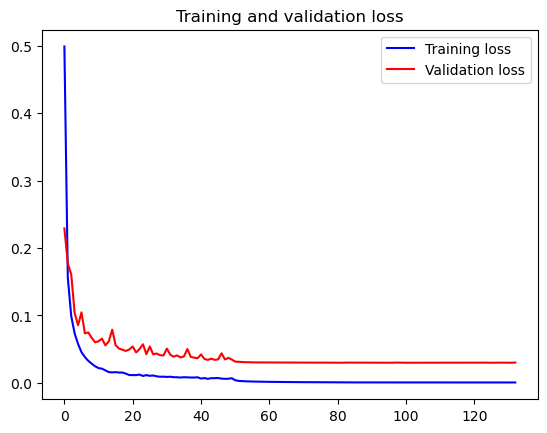

In [23]:
# plot the train&validation loss curve 
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history[:,0], 'b', label='Training loss')
plt.plot(epochs, val_history[:,0], 'r', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()


In [24]:
# save trained model
torch.save(mynet.state_dict(),'./models/mynet_stereo_2.pth')

In [26]:
mynet.load_state_dict(torch.load('./models/mynet_stereo_2.pth'))

<All keys matched successfully>

In [27]:
for i in range (21):
    TEST = random.randint (0, 1000)
    #TEST = 11730
    test_in, gt_X, gt_Y, gt_yaw = train_data[TEST]
    test_in = [torch.tensor(x).cuda() for x in test_in]
    gt_output = [gt_X, gt_Y, gt_yaw]
    gt_output = torch.tensor(gt_output).to(device)
    output_pred = mynet(test_in) 
    #print('TEST', TEST)
    #print('test_in',test_in)
    print('prediction:{}, ground truth:{}'.format(output_pred[0].cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

prediction:[ 7.5614033e+00 -4.8402491e-01 -2.9655844e-03], ground truth:[ 7.58151417e+00 -4.82345849e-01  6.05791163e-03]
prediction:[3.6827555  0.28081068 0.07914012], ground truth:[3.67470406 0.28874691 0.08086689]
prediction:[ 7.636112   -0.2829047  -0.07613102], ground truth:[ 7.6363717  -0.2680305  -0.08542236]
prediction:[6.8053217  0.61389375 0.01125951], ground truth:[6.79708655 0.59792432 0.01015721]
prediction:[ 7.4008927  -0.44465083  0.07542765], ground truth:[ 7.41607697 -0.43905128  0.0917975 ]
prediction:[ 7.9753346  -0.6242522  -0.01004441], ground truth:[ 7.98528567 -0.63764243 -0.02772631]
prediction:[ 7.481642   -0.39098883  0.08067732], ground truth:[ 7.51964682 -0.42835912  0.10961747]
prediction:[13.977055   -0.82753134  0.05066098], ground truth:[13.96736933 -0.80320351  0.03219263]
prediction:[6.525002   1.6095284  0.43099368], ground truth:[6.54800784 1.63122135 0.43541568]
prediction:[ 7.5668836   0.08701789 -0.05606847], ground truth:[ 7.5749393   0.07265572 

/home/melina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [34]:
for i in range (21):
    #TEST = random.randint (0, 2900)
    test_in, gt_X, gt_Y, gt_yaw, gt_th, gt_st = val_data[TEST]
    test_in = [torch.tensor(x).cuda() for x in test_in]
    gt_output = [gt_X, gt_Y, gt_yaw, gt_th, gt_st]
    gt_output = torch.tensor(gt_output).to(device)
    output_pred = mynet(test_in) 
    #print('TEST', TEST)
    #print('test_in',test_in)
    print('prediction:{}, ground truth:{}'.format(output_pred[:,:3].cpu().detach().numpy(), gt_output[:3].cpu().detach().numpy()))

IndexError: list index out of range

In [69]:
torch.cat((output_pred[0][:3], torch.tensor([1,2]).to(device)), axis = 0)

tensor([11.8419,  0.3709,  0.0354,  1.0000,  2.0000], device='cuda:0',
       grad_fn=<CatBackward0>)

In [67]:
torch.tensor([1]).shape

torch.Size([1])